## Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [49]:
import numpy as np
import pandas as pd
import pyarrow.feather as feather
import time


def convertDtype32(array):
    return np.array(array).astype("float32")

def convertDtype16(array):
    return np.array(array).astype("float16")

In [57]:
# imports


# load data
# datafile_path = "villa_database_with_embeddings.csv"

# df = pd.read_csv(datafile_path)
# df["embedding"] = df.embedding.apply(eval).apply(convertDtype32)  # convert string to numpy array
# df.to_feather("villa_database_with_float32_embeddings.feather")
start_time = time.time()
df = feather.read_feather("villa_database_with_float32_embeddings.feather")
time.time() - start_time
# matrix = np.vstack(df.embedding.values)
# matrix.shape


0.5281100273132324

In [56]:
# df["embedding"] = df.embedding.apply(convertDtype16)

In [20]:
for i in range(len(df.embedding.values[0])):
    df[f"embedding_{i}"] = df.embedding.apply(lambda x: x[i])

df.drop("pr_engname", axis=1, inplace=True)
df.drop("pr_name", axis=1, inplace=True)
df.drop("combined", axis=1, inplace=True)
df.drop("n_tokens", axis=1, inplace=True)
df.drop("embedding", axis=1, inplace=True)

"""PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 
which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. 
To get a de-fragmented frame, use `newframe = frame.copy()`"""

'PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, \nwhich has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. \nTo get a de-fragmented frame, use `newframe = frame.copy()`'

In [51]:
df16 = feather.read_feather("villa_database_with_float16_embeddings.feather")


In [32]:
df16["embedding"] = pd.concat(np.array([df16[f"embedding_{i}"] for i in range(1536)]), axis=0)

TypeError: cannot concatenate object of type '<class 'numpy.ndarray'>'; only Series and DataFrame objs are valid

In [24]:
dfNew = pd.concat([df, df.embedding.apply(pd.Series)], axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
65603    None
65604    None
65605    None
65606    None
65607    None
Name: embedding, Length: 65608, dtype: object

In [10]:
df = None
import pyarrow.feather as feather
df = feather.read_feather("villa_database_with_embeddings.feather")
# df["embedding"] = df.embedding.apply(convertDtype)  # convert string to numpy array

ArrowNotImplementedError: Not implemented type for Arrow list to pandas: halffloat

In [8]:
matrix = np.vstack(df.embedding.values)
print(matrix.shape)
type(df["embedding"][0].dtype)

(65608, 1536)


numpy.dtype[float16]

In [9]:
df.to_feather("villa_database_with_embeddings.feather")

### 1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [59]:
from sklearn.cluster import KMeans

n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels


/home/sam/anaconda3/envs/Python39/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [58]:
import pandas as pd, tiktoken, openai
from openai.embeddings_utils import get_embedding
openai.api_key = "key"
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
x = get_embedding("sun warrior", engine=embedding_model)
print(type(x))
# print(x)


<class 'list'>


In [14]:
x = np.array(x).reshape(1, -1)
x.dtype

dtype('float64')

In [7]:
kmeans.predict(x)

array([3], dtype=int32)

In [8]:
df["Cluster"]

0        1
1        1
2        1
3        3
4        0
        ..
65603    2
65604    4
65605    4
65606    0
65607    3
Name: Cluster, Length: 65608, dtype: int32

In [5]:
df.groupby()

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

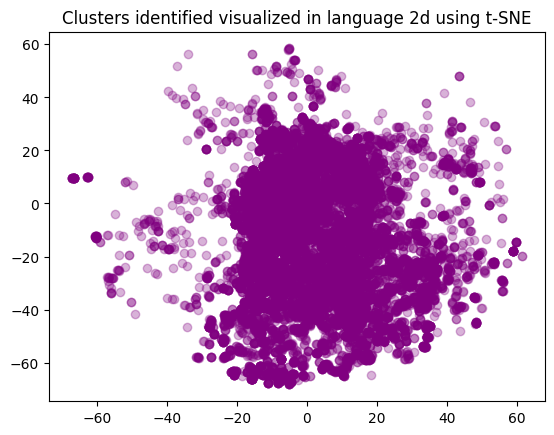

In [10]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue", "orange"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

### 2. Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use davinci-instruct-beta-v3 to name the clusters, based on a random sample of 6 reviews from that cluster.

In [8]:
import openai
openai.api_key = "key"
# Reading a review which belong to each group.
rev_per_cluster = 20

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")
    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What types of products are these\n\nItems:\n"""\n{reviews}\n"""',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

Cluster 0 Theme: 1. Misura Veggie Biscuit 120g2. Sada Natural Cane Stick Sugar 300g3. Sante Muesli Bar Cranberry 40g4. Pepsodent Sensitive Expert Original 100g5. Lorenz Crunchips Red Chilli 100g
Cluster 1 Theme: These products are toys, puzzles, flash cards, plush toys, and science kits.
Cluster 2 Theme: 1. YUPI Gummy Pizza 64g2. Streamline Strawberry Jam 340g3. Bourbon Alfort Matcha 168g4. Fair:D Premium Certified Organic Red Linguini 200g5. Nobel Soda Candy 88g6. By Bua Yellow Curry Concentrate
Cluster 3 Theme: These products are a mix of flowers, food items, and kitchenware. They include:- Lisianthus- Italian Bread- Wheat Crotssant HT- Rhubarb Crumble with Fresh Ginger and Custard Sauce- Costoluto Tomato- Ch.Mongrave
Cluster 4 Theme: These products are:1. Makfa Zoo มัคฟ่า ซู (Pasta Shaped Animal) 250g2. Holy Basil กระเพรา3. Chrysant
Cluster 5 Theme: These products are:1. Otento Apple Fuji (Huney Apple) Size S2. Pan 24cm. Peach Pink (EK-ER-F24)3. Standard Notebook F1564. Basket 120 B

In [60]:
for i in range(n_clusters):
    df2 = df[df["Cluster"] == i]
    df2.reset_index(inplace=True)
    df2.to_feather(f"cluster_{i}.feather")

In [10]:
df2 = df[df["Cluster"] == 0]
df2.reset_index(inplace=True)
df2["cprcode"]

0        49316
1        26321
2       210926
3       222237
4        38621
         ...  
5382    226388
5383     93063
5384    228526
5385    238082
5386    205603
Name: cprcode, Length: 5387, dtype: int64

In [24]:
(df2.embedding[0] +  df2.embedding[1] + df2.embedding[2]) / 3 #.embedding.values.shape

array([-0.01250787,  0.00113347,  0.01210418, ..., -0.03458749,
       -0.00800344, -0.00277752])

In [25]:
df2 = df[df["Cluster"] == 0]
avg = np.zeros(1536)
for embedding in range(len(df2.embedding)):
    avg += embedding
avg = avg / len(df2.embedding)

In [26]:
print(avg.shape)

(1536,)


In [61]:
df2 = None
avgs = []
total = 0
for i in range(n_clusters):
    df2 = df[df["Cluster"] == i]
    avg = np.zeros(1536)
    total += len(df2.embedding)
    for embedding in df2.embedding:
        avg = avg + embedding
    print(avg)
    avg = avg / len(df2.embedding)
    print(avg)
    avgs.append(avg)

[ -56.98898806 -196.26592772   49.45257527 ... -304.17184633   -6.97122209
 -136.12396812]
[-0.0033918  -0.01168111  0.00294326 ... -0.01810331 -0.0004149
 -0.00810165]
[-168.77198114 -170.28338959   48.9661399  ... -223.5603056    18.04020034
  -42.32436059]
[-0.01243439 -0.01254574  0.00360761 ... -0.01647096  0.00132912
 -0.00311828]
[ -40.87533404 -152.53747211   59.86137036 ...  -89.33897412 -118.03282588
 -154.08479535]
[-0.00282191 -0.01053072  0.00413265 ... -0.00616769 -0.00814862
 -0.01063754]
[  3.82201688 -48.70601808  -9.24724514 ... -58.4865752  -32.744299
  11.67047416]
[ 0.00081199 -0.01034757 -0.00196457 ... -0.01242545 -0.00695651
  0.00247939]
[-174.308274    -38.39036022   27.17356689 ... -294.976421     67.16594496
 -125.36533339]
[-0.01086642 -0.00239326  0.00169401 ... -0.0183889   0.00418714
 -0.00781531]


In [62]:
print(total)

65608


In [70]:
avgs[0]

array([-0.0033918 , -0.01168111,  0.00294326, ..., -0.01810331,
       -0.0004149 , -0.00810165])

In [85]:
data = {"embedding": avgs, "cluster": [i for i in range(n_clusters)]}
df3 = pd.DataFrame(data=data)

In [86]:
df3["embedding"] = df3.embedding.apply(convertDtype32)

In [81]:
df3["embedding"] = df3["embedding"].apply(lambda x: x[0])

In [92]:
df3[df3["cluster"] == 2].embedding

2    [-0.0028219079, -0.0105307195, 0.0041326457, -...
Name: embedding, dtype: object

In [93]:
df3.to_feather("villa_index_float32.feather")

In [94]:
df3 = feather.read_feather("villa_index_float32.feather")
df3[df3["cluster"] == 0]

,embedding,cluster
0,"[-0.003391798, -0.011681105, 0.0029432552, -0....",0


It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.